# Multi-modal RAG using Claude 3 Sonnet provided by Amazon Bedrock
Most of documents especially in finance domain, have a blend of content formats, such as textual data and visual representations such as bar charts and line graphs (images).

However, the information encapsulated within images is often disregarded in the majority of Retrieval-Augmented Generation (RAG) applications.

With the advent of multimodal Large Language Models (LLMs), like `Anthropic Claude 3 Sonnet`, it becomes relevant to explore methodologies for leveraging visual data in RAG applications.

## Steps followed in the notebook
1. Use a multimodal large language model (LLM), like Claude 3 Sonnet, to generate concise text descriptions from visual inputs (images).

2. Convert the textual summaries and raw image data into numerical representations (embeddings) and store them in a retrievable format, maintaining a linkage between the summaries and their corresponding images.

3. Feed the raw image data and relevant text chunks into a multimodal LLM, which can jointly process and synthesize information from both modalities to produce an answer.

We will use `pypdf` to parse images, and text from documents (PDFs).
We will use the [`multi-vector retriever`](#https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with Chroma DB to store raw text, tables and images along with their summaries for retrieval.

Reference:
[Multi-modal RAG](#https://github.com/sudarshan-koirala/youtube-stuffs/blob/main/langchain/LangChain_Multi_modal_RAG.ipynb) authored by Sudarshan Koirala

## Setup
Install required packages and import the libraries, which will be used throughout the notebook.
Make sure to restart the kernel after installing the packages.

In [8]:
%pip install pypdf
%pip install matplotlib scikit-image
%pip install ftfy regex tqdm
%pip install chromadb
%pip install sqlalchemy==2.0.0
%pip install --upgrade langchain>=0.1.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Download data

In [ ]:
!rm -r images
!mkdir images

In [ ]:
import urllib.request

url = "https://sgp.fas.org/crs/misc/IF10244.pdf"
filename = "wildfire_stats.pdf"
urllib.request.urlretrieve(url,filename)

## Extract images and text from the pdf

In [ ]:
path = "images"

In [ ]:
import langchain
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import TokenTextSplitter
from pypdf import PdfReader

reader = PdfReader(f"{filename}")
print('# of pages: ', len(reader.pages))
image_count = 0
texts = []

# extract and save images
for page in reader.pages:
    for image in page.images:
        image_count+=1
        with open(f"{path}/{image.name}", 'wb') as f:
            f.write(image.data)

loader = PyPDFLoader(filename)
documents = loader.load_and_split()

text_splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=0)

docs = text_splitter.split_documents(documents)
print("# of text chunks: ", len(docs))
print("# of images in document: ", image_count)

### Plot the images in the file

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./images"):
    image_paths.append(str(os.path.join("./images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if ".png" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            images_shown += 1
            if images_shown >= 9:
                break

print("Images in the document")
plot_images(image_paths)


## Create image summaries using Claude 3 Sonnet
We will use Claude 3 Sonnet model from Anthropic to create image summaries, which we will store in the `multi-vector retriever` from Langchain.

Before that, lets first set up a connection to the Anthropic Claude multimodal model using the AWS Bedrock service. Imports necessary libraries, configure the AWS Boto3 client, and initialize the Bedrock chat model interface using the LangChain library. 

In [6]:
import boto3
import pprint
from botocore.client import Config
import json
from langchain_community.chat_models.bedrock import BedrockChat

pp = pprint.PrettyPrinter(indent=2)
modelId = 'anthropic.claude-3-sonnet-20240229-v1:0' # change this to use a different version from the model provider
session = boto3.session.Session()
region = session.region_name
bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 0})
bedrock_client = boto3.client('bedrock-runtime', region_name = region)
print(region)
accept = 'application/json'
contentType = 'application/json'

us-east-1


Now we will define two functions: `encode_image` and `invoke_model_sonnet`. 
- The `encode_image` function takes an image file path as input and returns the base64 encoded string representation of the image file. 
- The `invoke_model_sonnet` function takes a base64 encoded image and a prompt as input, initializes a `BedrockChat` instance, creates a message list with the prompt and image, invokes the chat model, and returns the model's response.

In [7]:
import io
import os
import base64
import numpy as np
from PIL import Image
from langchain.chat_models.bedrock import BedrockChat
from langchain.schema.messages import HumanMessage, SystemMessage

def encode_image(image_path):
    ''' Getting the base64 string '''
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
def invoke_model_sonnet(img_base64,prompt):
    ''' Image summary '''
    chat = BedrockChat(model_id=modelId,
                      client=bedrock_client,
                      model_kwargs={
                      'temperature': 0.1, 
                      'top_p': 0.1
                  } 
                      )
    content = [
        {"type": "text", "text": prompt},
        {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": img_base64}}
        ]
    message_list = [
    {
        "role": 'user',
        "content": content
    }
]
    msg = chat.invoke(message_list)
    return msg.content

In [8]:

# Prompt
prompt = """
Summarize all the details in the image, focus on the statistics provided in the image such as bar charts and graphs. 
Make sure to include the time period in the summary, if available. For example, the images shows line graph showing data from 1993 to 2022.
"""

# Read images, encode to base64 strings
def create_image_summaries(input_files):
    img_base64_list = []
    image_summaries = []
    for file in input_files:
        print(file)
        base64_image = encode_image(file)
        image_summaries.append(invoke_model_sonnet(base64_image,prompt))
        img_base64_list.append(base64_image)
    return img_base64_list, image_summaries
img_base64_list, image_summaries = create_image_summaries(image_paths)



./images/Image11.png


/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `BedrockChat` was deprecated in LangChain 0.0.34 and will be removed in 0.3. An updated version of the class exists in the langchain-aws package and should be used instead. To use it run `pip install -U langchain-aws` and import as `from langchain_aws import ChatBedrock`.
  warn_deprecated(


./images/Image27.png
./images/Image29.png
./images/Image41.png
./images/Image43.png



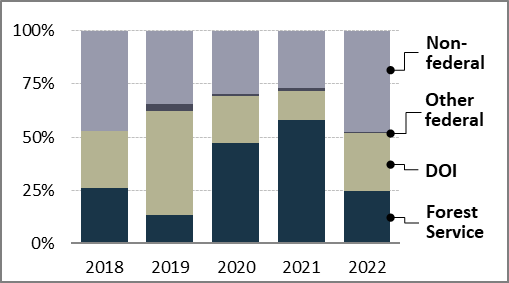

------------------ Image Summary ---------------
 The image shows a stacked bar chart displaying the distribution of wildfire suppression costs across different entities from 2018 to 2022 (projected). The bars are divided into four segments representing the Forest Service, Department of the Interior (DOI), Other federal agencies, and Non-federal entities.

In 2018 and 2019, the Forest Service accounted for the largest portion of the costs, followed by DOI, Other federal, and Non-federal entities.

However, in 2020 and 2021, DOI surpassed the Forest Service as the entity with the highest wildfire suppression costs.

For 2022, the projected costs show the Forest Service regaining the top position, followed by DOI, Non-federal entities, and Other federal agencies.

The time period covered in the chart spans from 2018 to 2022, providing an overview of the wildfire suppression cost distribution over the past few years and a projection for the current year.


In [9]:
# lets view the summary of one of the images
from IPython.display import display, HTML

def plt_img_base64(img_base64):

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

plt_img_base64(img_base64_list[3])
print("------------------ Image Summary ---------------\n", image_summaries[3])

## Add data into the Vector Store

Now we will set up the necessary components for a [multi-vector retriever](#https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) system using the Langchain library. We will import required modules, create an instance of the BedrockEmbeddings for text embeddings, initialize a Chroma vector store for indexing document chunks, and set up an in-memory store for parent documents. Finally, we will create a `MultiVectorRetriever` object, which combines the vector store and document store for efficient document retrieval based on vector embeddings.

In [11]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.embeddings import BedrockEmbeddings

embedding_model = f'cohere.embed-english-v3'
# instantiate embeddings model.
embedding_model = BedrockEmbeddings(
    client=bedrock_client,
    model_id=embedding_model
)
# define the vector store
vectorstore = Chroma(collection_name="multi_modal_rag",
                     embedding_function=embedding_model)

# define the storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# the retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [12]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in docs]
texts = []
for i, doc in enumerate(docs):
    doc.metadata.update({id_key: doc_ids[i]})
    texts.append(doc.page_content)
retriever.vectorstore.add_documents(docs)
retriever.docstore.mset(list(zip(doc_ids, texts)))

In [13]:
# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

### Verify the retrieved data
Now that we have added our text, image summaries and base64 images to the vector store, let's check that the retrieval is giving the relevant documents related to the query by following below steps: 
- We will first retrieve relevant documents using a retriever object and  write the helper function to split the retrieved documents into base64-encoded images and text chunks. 
- Finally print the number of retrieved images and text chunks. We will verify the result by displaying the first retrieved image, and printing the dictionary containing the separated images and text chunks.

In [14]:
docs = retriever.get_relevant_documents(
    "What is the change in wild fires from 1993 to 2022?"
)
len(docs)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


4

# images retrieved:  1
# of text chunk retrieved:  3
---------------- Retrieved Image -------------



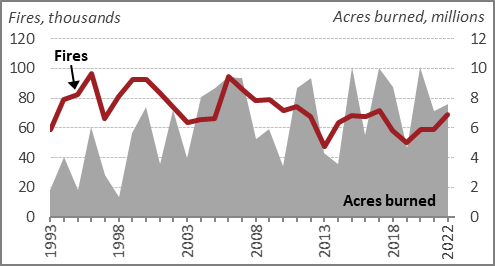

In [15]:
from base64 import b64decode
def split_image_text_types(docs):
    ''' Split base64-encoded images and texts '''
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {
        "images": b64,
        "texts": text
    }
docs_by_type = split_image_text_types(docs)
print("# images retrieved: ", len(docs_by_type["images"]))
print("# of text chunk retrieved: ", len(docs_by_type["texts"]))
print('---------------- Retrieved Image -------------')
if docs_by_type["images"]:
    plt_img_base64(docs_by_type["images"][0])

In [16]:

pprint.pp(docs_by_type["texts"][1])


('age Burned by Region and Ownership  \n'
 ' \n'
 'Source: NICC  Wildland Fire Summary and Statistics annual reports . \n'
 'Notes:  West: AK, AZ, CA, CO, ID, HI, MT, NM, NV, OR, UT, WA , \n'
 'and WY. East: All other states  and Puerto Rico.  Resources  \n'
 'Another metric useful for assessing wildfire activity is the \n'
 'extent to which nationwide resources —including personnel  \n'
 'and equipment —are engaged in  wildfire suppression . A \n'
 'proxy for resource commitments is the nationwide \n'
 'Preparedness Level  (PL) scale, which  ranges from 1 \n'
 '(lowest) to 5 (highest). The higher PLs indicate significant \n'
 'commitment of shared resources. In 2022, the nationwide \n'
 'level was 4 for 10 days and never reached the highest level \n'
 '(5). In contrast, t he highest level was reached for  68 days  in \n'
 '2021, the longest since at least 2000.  \n'
 'Wildfire Damages  \n'
 'Wildfires may affect  certain ecological resources  \n'
 'beneficially , but wildfires also ma

In [17]:
docs_by_type

{'images': ['iVBORw0KGgoAAAANSUhEUgAAAe8AAAEKCAYAAAA7AN38AABh7klEQVR4nO2de3wTZfb/P23SJG0pFFrYVspFWRRwEQpoQRZpERRYYUFF7jddYamrC+LlpxRRQf3yRQXhKyyuiqCCXVRYlSIWaRUEKpcUkUKt9AItKW1KaNq0aZJpfn/UGXOZ3Gdy63m/XrxezCUzJ0+ezmee85znnIgxY8a8NmrUqP8HgiAIgiCCHqVS+UHEqlWrzIE2hCAIgiAI95Gy/3nxxRcDaAZBEARBEK5gtToysGYQBEEQBOEpJN4EQRAEEWKQeBMEQRBEiEHiTRAEQRAhBok3QRAEQYQYJN4EQRAEEWKQeBMEQRBEiEHiTRAEEaaoVCrcf//9OH/+fKBN8YizZ89iwoQJuH79ut/uN27cOK6dbLeDkbAX71D4EXzB352cIAhrGIbB888/j4yMDBw6dCjQ5lihVCrR3NyM5OTkQJviEZcvX0aPHj2gUChEub6tLly+fBlSqZRrJ9vtYNQRt8VbpVJh0qRJyMjIsPrHdtZg/HKA/Y8QbojdyQmCcE5RURGOHTsGALh06VKArbGmvLw85J4PDMPgyJEj6Natm2h22+qCbTvZbgejjkhdn9KGUqmEyWTCnj17EB8fb3c80F/u7NmzePLJJ7Fx40b079+f2x+Knddd/NHJCYJwDMMw2LVrF+bMmYOLFy/i119/DbRJHAzDoLKyMuSeDwzD4OLFi5gwYYJo95g4cSImTpzI3a+yshJ33nknFAqF3bbt+cGC2yNvVyI4ceJE7N+/n1fY/cHly5dx44034sYbb+T28f0I4QTbyf/4xz8G2hSCaJccOHAASqUSDzzwAFJSUlBTUwO9Xm91jsFgwPTp0zlv5QcffMDtnzNnDs6cOcMdZz2Ztp9ZtGiR1XU3b95sdz1b2OfDmDFjHJ7P3sfS3W87T+7ITnb/zz//zE0b8E0duPoulsfHjRuHw4cPo6m

## Retrieval Augmented Generation workflow
Now that we have verified our retrievals, lets test our solution end to end.
- We will first define a function `prompt_func` that takes a dictionary as input and returns a list of messages formatted for a `Anthropic Claude 3 Sonnet` model. 
    - The function concatenates the text content from the input dictionary and formats it along with the `question` as a prompt for the model. It also includes any images from the input dictionary as base64-encoded data in the prompt. 
- Next, we will set up a pipeline using the LangChain library, to perform retrieval, followed by passing the retrieved data to the `prompt_func`, which sends the formatted prompt to `Claude 3 Sonnet model`, finally parsing the output using a string output parser (`StrOutputParser`). 
- We will then invoke the pipeline with the question to get the generated answer.

In [18]:
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.schema.output_parser import StrOutputParser

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    prompt = f'''Answer the question based only on the following context, which can include text and images:
    Question: {dict["question"]}
    Text:
    {format_texts}
    '''
    content = [{"type": "text", "text": prompt}]
    
    for image in dict["context"]["images"]: 
        content.append(
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": image}},
        )
    # pprint.pp(content)
    message_list = [
    {
        "role": 'user',
        "content": content
    }
]
    
    return message_list

chat_model = BedrockChat(model_id=modelId,
                      client=bedrock_client,
                       model_kwargs={
                      'temperature': 0.1, 
                      'top_p': 0.1
                  } )
# RAG pipeline
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | chat_model
    | StrOutputParser()
)

In [19]:
generated_answer = chain.invoke(
    "What is the change in wild fires from 1993 to 2022?"
)
pprint.pp(generated_answer)

('Based on the text and image provided, the number of wildfires has decreased '
 'slightly from 1993 to 2022, while the number of acres burned annually has '
 'generally increased over the same period.\n'
 '\n'
 'Specifically, the text states that "the number of annual wildfires is '
 'variable but has decreased slightly over the last 30 years." The image also '
 'shows a slight downward trend in the number of fires (red line) from the '
 'early 1990s to 2022.\n'
 '\n'
 'However, the text also notes that "the number of acres affected annually, '
 'while also variable, generally has increased." The image corroborates this, '
 'depicting an increasing trend in acres burned (gray bars) from the early '
 '1990s through 2022, despite some fluctuations year-to-year.\n'
 '\n'
 'So in summary, while the number of individual wildfire incidents has '
 'declined modestly since 1993, the total acreage impacted by wildfires each '
 'year has grown substantially over that same nearly 30-year period 

Please note that the above response uses both the retrieved text and images, to generate the final answer. 

## Conclusion
In this notebook, we provided the technique to build RAG applications which understand both text and visual data encapsulated in images to provide more relevant and accurate responses to the user. In this approach, we specifically leveraged multimodal Large Language Model (LLM), `Claude 3 Sonnet`, for leveraging both text and visual data for building our RAG application.